### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [5]:
%%time
canary_p = '../../../temp/ref_ccm.p'
pmpm_p = '../../../temp/pmpm_ccm.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pd.read_pickle(canary_p)
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 15 s, sys: 18.6 s, total: 33.6 s
Wall time: 2min 10s


pmpm.MEDICAID_LOB.unique()

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [6]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [7]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 34.4 s, sys: 18.5 s, total: 52.9 s
Wall time: 52.9 s


In [8]:
from utils import ip_er2

In [9]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)

CPU times: user 36.4 s, sys: 6.44 s, total: 42.9 s
Wall time: 42.8 s


In [10]:
%%time
pmpm[['IP_C', 'ER_C']] = pmpm.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
pmpm[['IP_BIN2', 'ER_BIN2']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(pmpm[['IP_C', 'ER_C']]).reset_index(drop = True)

CPU times: user 4min 5s, sys: 17.5 s, total: 4min 22s
Wall time: 4min 17s


#undersample
test = test.sample(random_state = 0, frac = 0.01).reset_index(drop = True)
test = test.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

%%time

test[['IP_C', 'ER_C']] = test.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
test[['IP_BIN2', 'ER_BIN2']] = test.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(test[['IP_C', 'ER_C']]).reset_index(drop = True)

In [11]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  2561295  201510        F               38        190       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   
1  2561295  201511        F               38          3       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   
2  2561295  201512        F               38          0       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [12]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 24.8 s, sys: 9.5 s, total: 34.3 s
Wall time: 34.3 s


In [13]:
canary.principal_reason.value_counts().head(5)

Other: please specify                                             10181
Behavioral Health Other (Specify under Additional Information)     8440
Coordination of Care                                               5296
High Risk Pregnancy                                                4139
Diabetes                                                           2950
Name: principal_reason, dtype: int64

In [14]:
%time
#reduce pmpm dimension and treated dimension
ids = list(pd.DataFrame(controls.PERS_ID.unique()).sample(frac = 0.02)[0])
controls = controls[controls.PERS_ID.isin(ids)].reset_index(drop = True)

#ids2 = list(pd.DataFrame(treated.PERS_ID.unique()).sample(frac = 0.005)[0])
#treated = treated[treated.PERS_ID.isin(ids2)].reset_index(drop = True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


### filter by principal reason

In [15]:
ids2 = canary[canary.principal_reason == "Diabetes"].PERS_ID.unique()
treated = treated[treated.PERS_ID.isin(ids2)].reset_index(drop = True)

In [16]:
controls.PERS_ID.unique().shape, treated.PERS_ID.unique().shape

Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [17]:
%%time
treated2 = in_canary(treated.copy(), canary2)
#treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 15.1 s, sys: 157 ms, total: 15.2 s
Wall time: 15.2 s


In [18]:
cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
columns_to_match = cols

#### Visualization of the clusters created in the previous step with a clustermap

In [19]:
%%time
"""
columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
hier_cols = ['IP_BIN2', 'ER_BIN2']
hier_range = [2,2]
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5, 'onset' : ""}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

"""
columns_to_match = cols
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" : 1}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)


Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Fitted: GradientBoostingClassifier
Creating Matched Set...


1it [00:00,  5.10it/s]

iter: 0


200it [00:39,  4.71it/s]

iter: 200


400it [01:25,  4.07it/s]

iter: 400


600it [02:17,  3.66it/s]

iter: 600


800it [03:15,  3.29it/s]

iter: 800


1000it [04:18,  3.07it/s]

iter: 1000


1200it [05:26,  2.82it/s]

iter: 1200


1400it [06:41,  2.62it/s]

iter: 1400


1556it [07:42,  3.36it/s]

CPU times: user 5min 47s, sys: 2min 33s, total: 8min 21s
Wall time: 7min 46s


####  In addition to the previously created matched groups create a random group

In [20]:
Path('./tempPropAll').mkdir(exist_ok = True)
p = './tempPropAll/'
matched_data0.to_pickle(p+'match0.p')
treated2.to_pickle(p+'treated0.p')

In [21]:
random_matching_func_args = {'neighbors_per_treated': 5}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [22]:
random_controls.to_pickle(p+'random.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [23]:
from utils import statistics_first_month

In [24]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [25]:
%%time
tr_desc0, Ntr, treated_first_month = statistics_first_month(treated2, columns_to_match, return_array = True)
tr_desc0 = tr_desc0.T



con_desc0, Ncon, controls_first_month = statistics_first_month(matched_data0, columns_to_match, return_array = True)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

pmpm_desc, Npmpm = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc, Nra = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 4min 51s, sys: 10.1 s, total: 5min 1s
Wall time: 5min 1s


In [26]:
import scipy.stats as sts

In [27]:
args = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'], 'mean2':con_desc0['mean'], 'std2':con_desc0['std'], 'nobs1': np.full(len(tr_desc0), Ntr) , 'nobs2': np.full(len(tr_desc0), Ncon)}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [28]:
alli = pd.concat((tr_desc0['mean'], con_desc0['mean'], stats, pmpm_desc['mean'], random_desc['mean']), axis = 1, keys = ['Treated', 'Matched Controls', 'T-Test', 'Genaral Population', 'Random'] )

## Statistics on matching date

In [29]:
alli

Treated Matched Controls    T-Test               Genaral Population      Random
                                   mean             mean    t-stat          pval               mean        mean
MBR_GNDR                       0.488875         0.529973 -1.839385  6.598711e-02           0.481626    0.476614
AGE_AT_MIDMONTH               53.714558        60.104905 -9.993200  4.770534e-23          35.256735   35.403143
ALLOW_AMT                   2592.286713      1764.235695  2.684949  7.306051e-03         501.015156  297.010036
ALLOW_ER                      33.188697        15.036335  2.261485  2.382208e-02          11.471588    8.075429
ALLOW_IP                    1116.429250       513.984237  2.492105  1.276860e-02         171.793307   37.706444
CC_ADHD                        0.014622         0.010899  0.723056  4.697190e-01           0.022007    0.030487
CC_ALZHEIMER                   0.002543         0.006812 -1.532169  1.256180e-01           0.002105    0.003030
CC_ALZHEIMER_PLUS              0.017800         0.028610 -1.677557  9.356910e-02           0.005594    0.005870
CC_AMI                         0.009536         0.013624 -0.883102  3.772734e-01           0.001062    0.000568
CC_ANEMIA                      0.116338         0.136240 -1.357095  1.748839e-01           0.031924    0.032759
CC_ANXIETY_DISORDER            0.161475         0.106267  3.526669  4.290418e-04           0.067816    0.087294
CC_ARTHRITIS                   0.183725         0.166213  1.023677  3.060954e-01           0.051064    0.060973
CC_ASTHMA                      0.086459         0.038147  4.220268  2.534641e-05           0.027044    0.030865
CC_ATRIAL_FIB                  0.030515         0.077657 -5.085965  3.952462e-07           0.009851    0.010983
CC_AUTISM                      0.000636         0.001362 -0.552158  5.808937e-01           0.002990    0.004166
CC_BIPOLAR                     0.036872         0.017711  2.484177  1.305564e-02           0.014018    0.014959
CC_BPH                         0.026701         0.047684 -2.616187  8.949836e-03           0.008959    0.011551
CC_BREAST_CANCER               0.014622         0.020436 -1.021713  3.070239e-01           0.006817    0.005491
CC_CATARACT                    0.047044         0.107629 -5.479728  4.723560e-08           0.026714    0.029540
CC_CEREBRAL_PALSY              0.002543         0.000000  1.367345  1.716504e-01           0.000634    0.001136
CC_CHRONIC_KIDNEY              0.375079         0.239782  6.482537  1.099618e-10           0.020383    0.019125
CC_COLORECTAL_CANCER           0.006993         0.016349 -2.107820  3.515431e-02           0.001643    0.002840
CC_COPD                        0.073109         0.081744 -0.729383  4.658414e-01           0.015836    0.016474
CC_CYSTIC_FIBROSIS             0.001907         0.002725 -0.393162  6.942359e-01           0.001112    0.000757
CC_DEPRESSION                  0.205976         0.123978  4.797580  1.708608e-06           0.069052    0.075933
CC_DEPRESSIVE_DISORDERS        0.001271         0.001362 -0.056430  9.550041e-01           0.001932    0.000757
CC_DEVELOP_DELAYS              0.000000         0.000000       NaN           NaN           0.001277    0.001515
CC_DIABETES                    0.930070         1.000000 -7.425640  1.571072e-13           0.048521    0.000000
CC_DISAB_DX_CNT                0.073109         0.072207  0.069568  9.445433e-01           0.031654    0.045257
CC_DX_CNT                      4.882390         4.765668  0.906525  3.647530e-01           0.920962    0.980307
CC_ENDOMETRIAL_CANCER          0.002543         0.001362  0.567690  5.703004e-01           0.000646    0.000000
CC_EPILEPSY                    0.015893         0.006812  1.793710  7.299048e-02           0.005061    0.005491
CC_FIBROMYALGIA                0.113795         0.079019  2.565015  1.037992e-02           0.026702    0.044310
CC_GLAUCOMA                    0.056580         0.083106 -2.408811  1.608257e-02           0.025808    0.030108


In [30]:
tr_desc0A = treated2[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0A = tr_desc0A.T


con_desc0A = matched_data0[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0A = con_desc0A.T


pmpm_descA = pmpm2[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_descA = pmpm_descA.T

random_descA = random_controls[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_descA = random_descA.T



#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [31]:
args = {'mean1':tr_desc0A['mean'], 'std1':tr_desc0A['std'],
        'mean2':con_desc0A['mean'], 'std2':con_desc0A['std'],
        'nobs1': np.full(len(tr_desc0), len(treated2)) , 'nobs2': np.full(len(tr_desc0), len(matched_data0))}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [32]:
alli2 = pd.concat((tr_desc0A, con_desc0A, stats['pval'], pmpm_descA['mean'], random_descA['mean']), axis = 1, keys = ['Treated',
                                                                                 'Matched Controls','T-Test',
                                                                                'Genaral Population', 
                                                                                 'Random'] )
alli2

Treated              Matched Controls                      T-Test Genaral Population      Random
                                   mean          std             mean          std           pval               mean        mean
MBR_GNDR                       0.476004     0.499429         0.510666     0.499897   1.347951e-18           0.471587    0.470983
AGE_AT_MIDMONTH               56.332532    13.425710        61.734885    14.137012   0.000000e+00          38.128488   37.353922
ALLOW_AMT                   1558.852301  7860.085366      1249.300206  4510.060800   1.656308e-08         486.846157  353.807329
ALLOW_ER                      22.322960   180.543278        13.803990   160.049637   5.478302e-10          11.125583    9.564208
ALLOW_IP                     368.892439  7025.868457       234.290854  3333.533034   5.003094e-03         101.929426   53.140925
CC_ADHD                        0.017806     0.132248         0.009593     0.097476   1.437638e-17           0.036073    0.037278
CC_ALZHEIMER                   0.003485     0.058933         0.008121     0.089749   6.403110e-17           0.003468    0.002843
CC_ALZHEIMER_PLUS              0.016064     0.125722         0.028906     0.167545   4.822251e-31           0.010242    0.007219
CC_AMI                         0.010596     0.102390         0.004165     0.064407   6.744896e-19           0.001597    0.000674
CC_ANEMIA                      0.128630     0.334794         0.126941     0.332914   5.211540e-01           0.046129    0.038185
CC_ANXIETY_DISORDER            0.217742     0.412715         0.123617     0.329151  4.822363e-207           0.120416    0.112171
CC_ARTHRITIS                   0.206586     0.404860         0.192620     0.394365   1.017290e-05           0.082195    0.074740
CC_ASTHMA                      0.089853     0.285974         0.047503     0.212716   1.805664e-91           0.041812    0.034710
CC_ATRIAL_FIB                  0.038217     0.191721         0.072201     0.258826   1.015719e-88           0.017098    0.013053
CC_AUTISM                      0.001602     0.039998         0.000631     0.025115   5.928887e-04           0.006214    0.005859
CC_BIPOLAR                     0.043464     0.203902         0.019859     0.139520   1.713411e-58           0.022008    0.015143
CC_BPH                         0.030786     0.172738         0.071780     0.258129  1.645444e-142           0.014922    0.013255
CC_BREAST_CANCER               0.019329     0.137679         0.021753     0.145879   2.842566e-02           0.010350    0.007881
CC_CATARACT                    0.085246     0.279250         0.118694     0.323435   4.160900e-47           0.041644    0.040385
CC_CEREBRAL_PALSY              0.002564     0.050569         0.002987     0.054576   3.003790e-01           0.001638    0.001698
CC_CHRONIC_KIDNEY              0.471398     0.499186         0.390457     0.487863   3.821561e-95           0.047831    0.025279
CC_COLORECTAL_CANCER           0.008953     0.094198         0.018976     0.136443   4.265139e-31           0.002381    0.002310
CC_COPD                        0.093198     0.290713         0.085497     0.279625   6.673095e-04           0.024483    0.017919
CC_CYSTIC_FIBROSIS             0.003385     0.058083         0.001220     0.034910   1.113609e-07           0.001874    0.000435
CC_DEPRESSION                  0.240396     0.427328         0.147305     0.354417  9.874314e-186           0.107131    0.089888
CC_DEPRESSIVE_DISORDERS        0.004286     0.065330         0.000210     0.014503   2.009266e-21           0.003219    0.001269
CC_DEVELOP_DELAYS              0.000761     0.027578         0.000000     0.000000   2.095316e-05           0.002964    0.003040
CC_DIABETES                    0.953091     0.211447         0.932133     0.251523   3.638840e-32           0.070631    0.010963
CC_DISAB_DX_CNT                0.095441     0.331979         0.082551     0.300077   3.802939e-07           0.060959    0.061815
CC_DX_CNT                      5.

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [33]:
#mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco use', 'Pressure', 'Obesity', 
                                     #'Hypertension', 'Hypothyroid', 'Disease Count', 'Inpatient Visits', 'Emergency Vistits', 'Line of Bussiness']))
mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [34]:
p = Path('./res/figs')
p.mkdir(parents = True, exist_ok = True)

In [35]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

1. treated_first_month
2. controls_first_month

In [36]:
from diabetes_onset_plotter import plot_hist


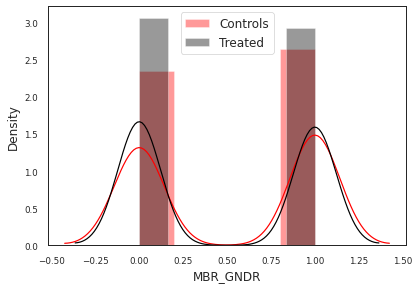

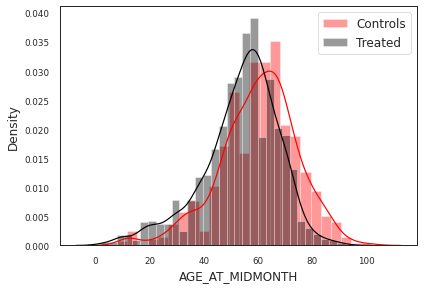

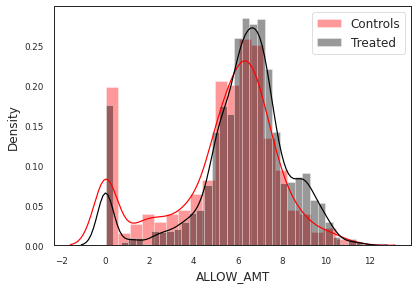

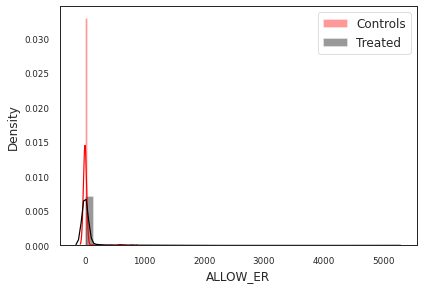

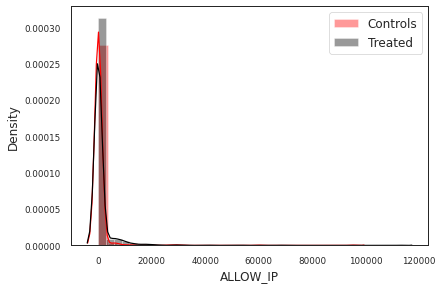

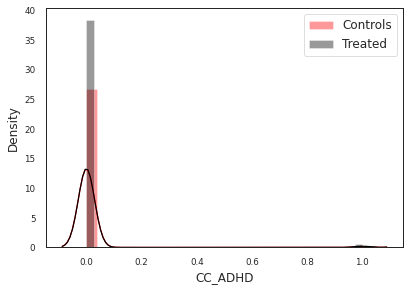

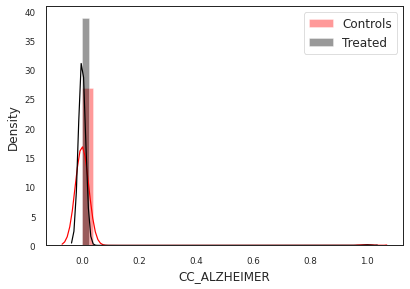

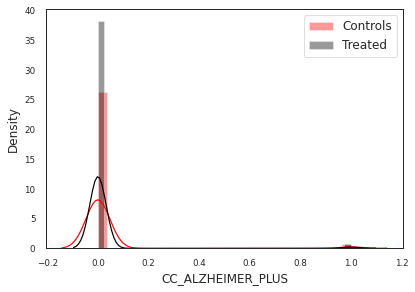

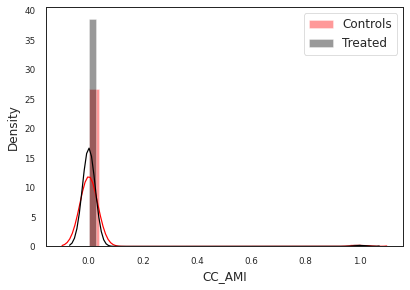

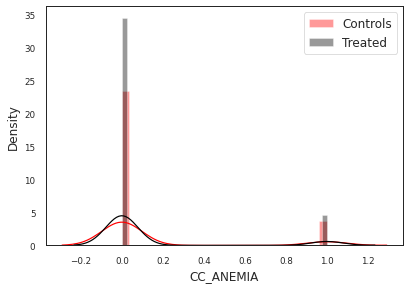

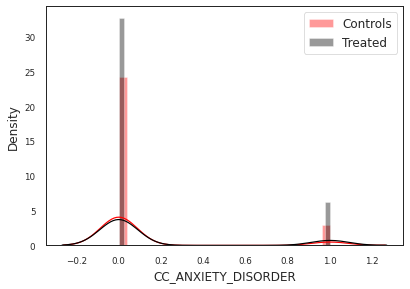

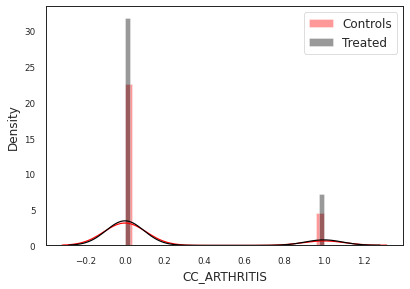

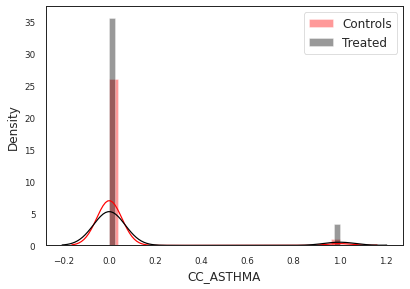

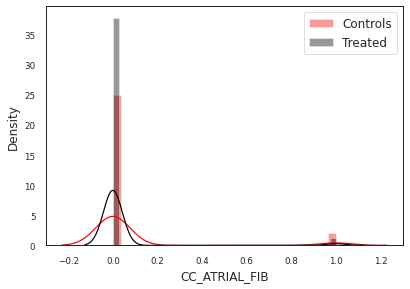

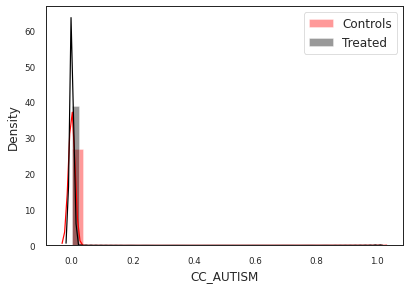

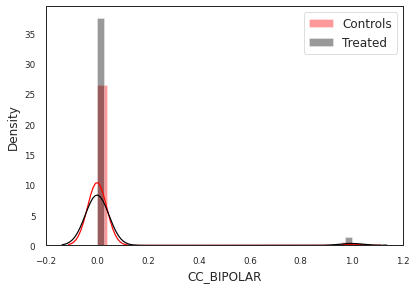

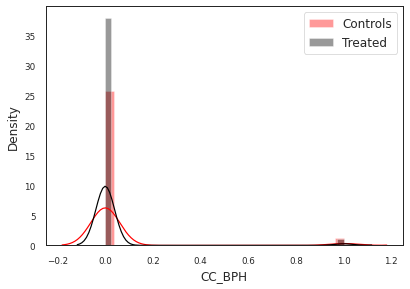

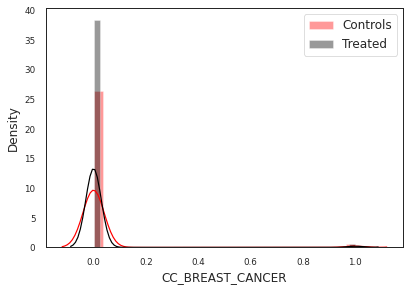

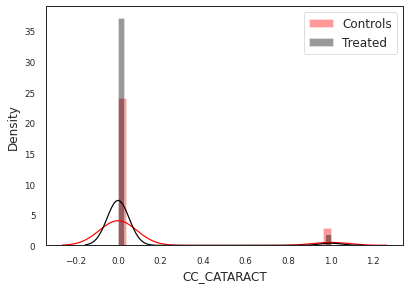

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density. Either provide the bandwidth during initialization or use an alternative method.

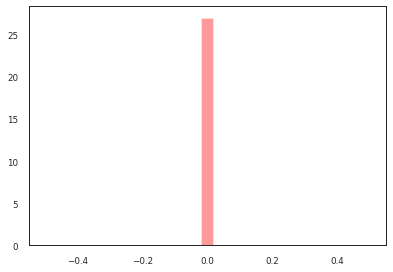

In [37]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = 'res/figs/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

In [38]:
from diabetes_onset_plotter import save_arrays
p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

In [39]:
all_paper


Treated  Matched Controls  T-Statistic  p-value  General Population  Random Match  Difference
MBR_GNDR                       0.489             0.530       -1.839    0.066               0.482         0.477      -0.041
AGE_AT_MIDMONTH               53.715            60.105       -9.993    0.000              35.257        35.403      -6.390
ALLOW_AMT                   2592.287          1764.236        2.685    0.007             501.015       297.010     828.051
ALLOW_ER                      33.189            15.036        2.261    0.024              11.472         8.075      18.153
ALLOW_IP                    1116.429           513.984        2.492    0.013             171.793        37.706     602.445
CC_ADHD                        0.015             0.011        0.723    0.470               0.022         0.030       0.004
CC_ALZHEIMER                   0.003             0.007       -1.532    0.126               0.002         0.003      -0.004
CC_ALZHEIMER_PLUS              0.018             0.029       -1.678    0.094               0.006         0.006      -0.011
CC_AMI                         0.010             0.014       -0.883    0.377               0.001         0.001      -0.004
CC_ANEMIA                      0.116             0.136       -1.357    0.175               0.032         0.033      -0.020
CC_ANXIETY_DISORDER            0.161             0.106        3.527    0.000               0.068         0.087       0.055
CC_ARTHRITIS                   0.184             0.166        1.024    0.306               0.051         0.061       0.018
CC_ASTHMA                      0.086             0.038        4.220    0.000               0.027         0.031       0.048
CC_ATRIAL_FIB                  0.031             0.078       -5.086    0.000               0.010         0.011      -0.047
CC_AUTISM                      0.001             0.001       -0.552    0.581               0.003         0.004       0.000
CC_BIPOLAR                     0.037             0.018        2.484    0.013               0.014         0.015       0.019
CC_BPH                         0.027             0.048       -2.616    0.009               0.009         0.012      -0.021
CC_BREAST_CANCER               0.015             0.020       -1.022    0.307               0.007         0.005      -0.005
CC_CATARACT                    0.047             0.108       -5.480    0.000               0.027         0.030      -0.061
CC_CEREBRAL_PALSY              0.003             0.000        1.367    0.172               0.001         0.001       0.003
CC_CHRONIC_KIDNEY              0.375             0.240        6.483    0.000               0.020         0.019       0.135
CC_COLORECTAL_CANCER           0.007             0.016       -2.108    0.035               0.002         0.003      -0.009
CC_COPD                        0.073             0.082       -0.729    0.466               0.016         0.016      -0.009
CC_CYSTIC_FIBROSIS             0.002             0.003       -0.393    0.694               0.001         0.001      -0.001
CC_DEPRESSION                  0.206             0.124        4.798    0.000               0.069         0.076       0.082
CC_DEPRESSIVE_DISORDERS        0.001             0.001       -0.056    0.955               0.002         0.001       0.000
CC_DEVELOP_DELAYS              0.000             0.000          NaN      NaN               0.001         0.002       0.000
CC_DIABETES                    0.930             1.000       -7.426    0.000               0.049         0.000      -0.070
CC_DISAB_DX_CNT                0.073             0.072        0.070    0.945               0.032         0.045       0.001
CC_DX_CNT                      4.882             4.766        0.907    0.365               0.921         0.980       0.116
CC_ENDOMETRIAL_CANCER          0.003             0.001        0.568    0.570               0.001         0.000       0.002
CC_EPILEPSY                    0.016             0.007        1.794    0.073               0.

In [40]:
only_means

Treated  Matched Controls  General Population  Random Match
MBR_GNDR                       0.489             0.530               0.482         0.477
AGE_AT_MIDMONTH               53.715            60.105              35.257        35.403
ALLOW_AMT                   2592.287          1764.236             501.015       297.010
ALLOW_ER                      33.189            15.036              11.472         8.075
ALLOW_IP                    1116.429           513.984             171.793        37.706
CC_ADHD                        0.015             0.011               0.022         0.030
CC_ALZHEIMER                   0.003             0.007               0.002         0.003
CC_ALZHEIMER_PLUS              0.018             0.029               0.006         0.006
CC_AMI                         0.010             0.014               0.001         0.001
CC_ANEMIA                      0.116             0.136               0.032         0.033
CC_ANXIETY_DISORDER            0.161             0.106               0.068         0.087
CC_ARTHRITIS                   0.184             0.166               0.051         0.061
CC_ASTHMA                      0.086             0.038               0.027         0.031
CC_ATRIAL_FIB                  0.031             0.078               0.010         0.011
CC_AUTISM                      0.001             0.001               0.003         0.004
CC_BIPOLAR                     0.037             0.018               0.014         0.015
CC_BPH                         0.027             0.048               0.009         0.012
CC_BREAST_CANCER               0.015             0.020               0.007         0.005
CC_CATARACT                    0.047             0.108               0.027         0.030
CC_CEREBRAL_PALSY              0.003             0.000               0.001         0.001
CC_CHRONIC_KIDNEY              0.375             0.240               0.020         0.019
CC_COLORECTAL_CANCER           0.007             0.016               0.002         0.003
CC_COPD                        0.073             0.082               0.016         0.016
CC_CYSTIC_FIBROSIS             0.002             0.003               0.001         0.001
CC_DEPRESSION                  0.206             0.124               0.069         0.076
CC_DEPRESSIVE_DISORDERS        0.001             0.001               0.002         0.001
CC_DEVELOP_DELAYS              0.000             0.000               0.001         0.002
CC_DIABETES                    0.930             1.000               0.049         0.000
CC_DISAB_DX_CNT                0.073             0.072               0.032         0.045
CC_DX_CNT                      4.882             4.766               0.921         0.980
CC_ENDOMETRIAL_CANCER          0.003             0.001               0.001         0.000
CC_EPILEPSY                    0.016             0.007               0.005         0.005
CC_FIBROMYALGIA                0.114             0.079               0.027         0.044
CC_GLAUCOMA                    0.057             0.083               0.026         0.030
CC_HEARING_IMPAIR              0.032             0.033               0.011         0.018
CC_HEART_FAILURE               0.064             0.095               0.013         0.010
CC_HEPATITIS_A                 0.000             0.000               0.000         0.000
CC_HEPATITIS_B_ACUTE           0.001             0.000               0.000         0.000
CC_HEPATITIS_B_CHRONIC         0.001             0.001               0.000         0.000
CC_HEPATITIS_C_ACUTE           0.003             0.000               0.000         0.000
CC_HEPATITIS_C_CHRONIC         0.008             0.007               0.002         0.002
CC_HEPATITIS_C_UNSPECIFIED     0.011             0.005               0.001         0.001
CC_HEPATITIS_D                 0.000             0.000               0.000         0.000
CC_HEPATITIS_E                 0.000             0.000               0.000         0.000
CC_HEPATITIS_GEN        

In [41]:
only_stats

Difference  T-Statistic  p-value
MBR_GNDR                        -0.041       -1.839    0.066
AGE_AT_MIDMONTH                 -6.390       -9.993    0.000
ALLOW_AMT                      828.051        2.685    0.007
ALLOW_ER                        18.153        2.261    0.024
ALLOW_IP                       602.445        2.492    0.013
CC_ADHD                          0.004        0.723    0.470
CC_ALZHEIMER                    -0.004       -1.532    0.126
CC_ALZHEIMER_PLUS               -0.011       -1.678    0.094
CC_AMI                          -0.004       -0.883    0.377
CC_ANEMIA                       -0.020       -1.357    0.175
CC_ANXIETY_DISORDER              0.055        3.527    0.000
CC_ARTHRITIS                     0.018        1.024    0.306
CC_ASTHMA                        0.048        4.220    0.000
CC_ATRIAL_FIB                   -0.047       -5.086    0.000
CC_AUTISM                        0.000       -0.552    0.581
CC_BIPOLAR                       0.019        2.484    0.013
CC_BPH                          -0.021       -2.616    0.009
CC_BREAST_CANCER                -0.005       -1.022    0.307
CC_CATARACT                     -0.061       -5.480    0.000
CC_CEREBRAL_PALSY                0.003        1.367    0.172
CC_CHRONIC_KIDNEY                0.135        6.483    0.000
CC_COLORECTAL_CANCER            -0.009       -2.108    0.035
CC_COPD                         -0.009       -0.729    0.466
CC_CYSTIC_FIBROSIS              -0.001       -0.393    0.694
CC_DEPRESSION                    0.082        4.798    0.000
CC_DEPRESSIVE_DISORDERS          0.000       -0.056    0.955
CC_DEVELOP_DELAYS                0.000          NaN      NaN
CC_DIABETES                     -0.070       -7.426    0.000
CC_DISAB_DX_CNT                  0.001        0.070    0.945
CC_DX_CNT                        0.116        0.907    0.365
CC_ENDOMETRIAL_CANCER            0.002        0.568    0.570
CC_EPILEPSY                      0.009        1.794    0.073
CC_FIBROMYALGIA                  0.035        2.565    0.010
CC_GLAUCOMA                     -0.026       -2.409    0.016
CC_HEARING_IMPAIR               -0.001       -0.116    0.908
CC_HEART_FAILURE                -0.031       -2.726    0.006
CC_HEPATITIS_A                   0.000          NaN      NaN
CC_HEPATITIS_B_ACUTE             0.001        0.966    0.334
CC_HEPATITIS_B_CHRONIC           0.000       -0.552    0.581
CC_HEPATITIS_C_ACUTE             0.003        1.367    0.172
CC_HEPATITIS_C_CHRONIC           0.001        0.369    0.712
CC_HEPATITIS_C_UNSPECIFIED       0.006        1.262    0.207
CC_HEPATITIS_D                   0.000          NaN      NaN
CC_HEPATITIS_E                   0.000          NaN      NaN
CC_HEPATITIS_GEN                 0.001        0.303    0.762
CC_HIP_FRACTURE                 -0.002       -1.297    0.195
CC_HYPERLIPIDEMIA               -0.055       -2.478    0.013
CC_HYPERTENSION                 -0.042       -1.933    0.053
CC_HYPOTHYROID                  -0.004       -0.229    0.819
CC_INT_DISAB                     0.000       -0.080    0.936
CC_ISCHEMIC                     -0.040       -2.198    0.028
CC_LEARN_DISAB                   0.000       -0.056    0.955
CC_LEUKEMIAS                    -0.006       -1.462    0.144
CC_LIVER                         0.016        1.485    0.138
CC_LUNG_CANCER                  -0.001       -0.628    0.530
CC_MIGRAINE                      0.012        1.535    0.125
CC_MOBILITY_IMPAIR               0.000        0.049    0.961
CC_MULTIPLE_SCLEROSIS            0.000       -0.080    0.936
CC_MUSCULAR_DYSTROPHY            0.001        0.683    0.495
CC_OBESITY                       0.077        3.555    0.000
CC_OSTEOPOROSIS                 -0.016       -3.481    0.001
CC_PERIPHERAL                   -0.001       -0.080    0.936
CC_PERSONALITY                   0.015        2.827    0.005
CC_PRESSURE                      0.000        0.009    0.993
CC_PROSTATE_CANCER              -0.008       -1.747    0.081
CC

In [42]:
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'IP_BIN2', 'ER_BIN2']
only_means.loc[columns_to_match]

Treated  Matched Controls  General Population  Random Match
AGE_AT_MIDMONTH    53.715            60.105              35.257        35.403
ALLOW_AMT        2592.287          1764.236             501.015       297.010
MBR_GNDR            0.489             0.530               0.482         0.477
CC_TOBACCO          0.174             0.099               0.041         0.043
CC_PRESSURE         0.046             0.046               0.004         0.004
CC_OBESITY          0.390             0.313               0.050         0.054
CC_HYPERTENSION     0.598             0.640               0.102         0.106
CC_HYPOTHYROID      0.100             0.104               0.025         0.032
CC_DX_CNT           4.882             4.766               0.921         0.980
IP_BIN2             0.174             0.074               0.018         0.020
ER_BIN2             0.256             0.080               0.022         0.085